# Machine Learning and Computational Statistics - 3rd Assignment

### Dimitris Tsirmpas

## Multiple Choise Questions

| Exercise | Answers |
| --- | --- | 
| 1 | 1, 4 | 
| 2 | 2, 4| 
| 3 | 2, 3 |
| 4 | 2 |
| 5 | 1, 2, 4 |
| 6 | 1,4 |
| 7 | 2 |
| 8 | 1 |
| 9 | 1,3 |
| 10 | 1, 4 |
| 11 | 2, 3, 4 |
| 12 | 1, 3 |
| 13 | a-1, b-2, c-2 |
| 14 | 1, 4 |
| 15 | 4 |
| 16 | 1, 2 |
| 17 | 1 |

Note: This notebook uses progress bars, which are supplied by the `tqdm` library.

In [1]:
%%capture
!pip install tqdm

## Importing the Code

Before we start, we should import the code from the previous assignments in order to not repeat the usual regression algorithms. This time, we will define a custom "LS_Model" class which will hopefully make the syntax and debugging a little easier. 

Some of the functions we defined in the previous assignements are imported as methods, while others (such as the MSE) remain as free functions since they may be used outside of the scope of a LS model. 

In [2]:
import numpy as np


def mse(y_hat: np.array, y: np.array) -> float:
    """
    Calculate the Mean Squared Error between the predictions and actual values.
    :param y_hat: A Nx1 prediction vector
    :param y: A Nx1 vector containing the actual values
    :return: the MSE error
    """
    return np.mean((y - y_hat)**2)


def polynomial(x: np.ndarray, degree: int) -> np.ndarray:
    """
    Raise a vector to a N-degree polynomial.
    :param x: a Lx1 sized vector
    :param degree: the degree of the polynomial
    :return: a Lx(degree+1) vector representing the Nth degree polynomial of the original vector 
    """
    x8 = np.column_stack([np.power(x, i) for i in range(degree + 1)])
    
    # discard useless 3rd dimension if exists
    if x8.ndim == 3: 
        return x8[:,:,0]
    else:
        return x8

In [3]:
class LS_Model:
    """
    A class representing a linear regression model, with a X data matrix and a y value vector.
    """
    
    # Pretend there is a return type hint here
    # if we declare it we somehow reach a cyclical dependency, where the type hint is declared before the class
    @classmethod
    def from_normal_dataset(cls, mean: np.ndarray, cov: np.ndarray, size: int):
        """
        Generate a new LS_Model based on a datast following the Normal distribution with a set mean and covariance matrix.
        :param mean: a Mx1 vector of the r.v's mean (where M the number of features)
        :param cov: a MxM covariance matrix (where M the number of features)
        :param size: the size of the LS_Model
        :return: a LS_Model with Nx1 explanatory variable vector and a Nx(M+1) data vector, where the first row is filled with ones
        """
        data = np.random.multivariate_normal(mean=mean, cov=cov, size=size) 
        return LS_Model(y=data[:,0],  x=data[:,1], include_coef_col=True) 
    
    def __init__(this, y: np.ndarray, x: np.ndarray, ridge: float = 0, include_coef_col: bool = False):
        """
        Construct a new model with the associated X data matrix and y values.
        :param x: a NxM data matrix
        :param y: a Nx1 value vector
        :param ridge: the ridge regression term, 0 for ordinary least squares (default 0)
        :param include_coef_col: whether to add an all-ones column in the X matrix to support estimation
        of the intercept, default False
        """
        if include_coef_col:
            this.x = np.column_stack([np.ones_like(x), x])
        else:
            this.x = x
        
        this.ridge = ridge
        this.y = y
        
    def fit(this, lamda: float = 0) -> np.array:
        """
        Perform linear regression using the sum of error squares criterion.
        :return: the theta vector of size Mx1 containing the model parameters
        """
        X = this.x
        y = this.y

        if this.ridge < 0:
            raise ValueError("Lamda values must be equal to, or larger than 0.")

        # if X is a vector and not matrix, turn it into a matrix as
        # vector @ vector => float, but matrix @ vector => vector
        if X.ndim < 2:
            X = X.reshape(-1, 1)

        inverted = X.T@X + this.ridge * np.identity(X.shape[1]-1) # ridge regression term
        if np.linalg.det(inverted) == 0:
            print("Warning: X^TX not invertible, solution is not unique")

        # mutiply the inverse of X^T with X^T and y
        # the result is our theta vector
        return np.linalg.inv(inverted) @ X.T @ y 
    
    def estimate(this, theta: np.ndarray=None) -> np.ndarray:
        """
        Get the LS estimation for the LS_Model's X matrix based on generated weights.
        :param theta: a Mx1 vector of the LS model's parameters (where M the number of features)
        None to calculate the parameters automatically. Default: None.
        :return: a Nx1 vector containing the y_hat estimations
        """
        if theta is None:
            theta = this.fit()
        return this.x @ theta
    
    def mse(this, estimates: np.ndarray=None) -> float:
        """
        Get the MSE for the current model. This is a wrapper method for the MSE free function.
        :param estimates: a Nx1 vector containing the y_hat estimations, 
        None to calculate estimations automatically. Default: None.
        :return: the MSE of the model
        """
        if estimates is None:
            estimates = this.estimate(this.fit())
        return mse(this.y, estimates)

## Exercise 18

We import the data as usual and place them in a LS_Model.

In [4]:
import scipy.io as sio

Training_Set = sio.loadmat('Training_Set.mat')
X = Training_Set['X']
y = Training_Set['y']

model = LS_Model(x=X, y=y)

We will now fit 6 different LASSO estimators fitted on the same LS_Model, but with different $\lambda$ values in order to observe the effect of regularization on the generated functions.

The first (blue) model will be a regular LS estimator with no regularization, while the following ones will be of size $[10^{-6},10^{-5}, \cdots, 10^{0}]$. 

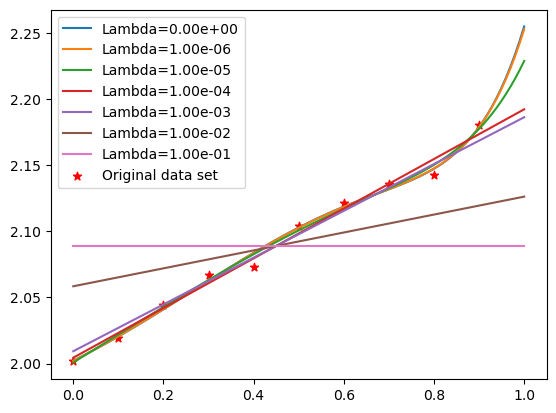

In [5]:
from sklearn.linear_model import Lasso as lasso
import matplotlib.pyplot as plt
import warnings


param_ls = []
lamda_ls = np.insert(np.logspace(-6, -1, 6), 0, 0)
plot_x = np.linspace(0, 1, 100).reshape(-1,1)

for lamda in lamda_ls:
    # Fitting a regularization model with no or very small regularization
    # understandably raises warnings from the library.
    # We are suppressing them here, as our models are purely for demonstrative purposes
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        fitted = lasso(alpha=lamda).fit(polynomial(model.x, 8), model.y)
        param_ls.append(np.insert(fitted.coef_[1:], 0, fitted.intercept_))
        plt.plot(plot_x, fitted.predict(polynomial(plot_x, 8)), label=f"Lambda={lamda:.2e}")
    
plt.scatter(X, y, color="red", marker="*", label="Original data set")
plt.legend()
plt.show()

We can have a look at the generated parameters by placing them on a table as such:

In [6]:
import pandas as pd


param_matrix = np.array(param_ls)
column_names = ["Lambda", "Intercept"] + [f"Theta(x^{i})" for i in range(1, param_matrix.shape[1]) ] 

df = pd.concat([pd.DataFrame(lamda_ls), pd.DataFrame(param_matrix)], axis=1)
df.columns = column_names
df = df.set_index("Lambda")
df

,Intercept,Theta(x^1),Theta(x^2),Theta(x^3),Theta(x^4),Theta(x^5),Theta(x^6),Theta(x^7),Theta(x^8)
Lambda,,,,,,,,,
0.000000,2.002167,0.169956,0.140984,-0.076245,-0.129368,-0.097494,-0.017292,0.081611,0.180434
0.000001,2.001990,0.175475,0.119992,-0.061093,-0.124545,-0.084868,-0.010771,0.038251,0.198280
0.000010,2.000818,0.210555,0.000000,-0.005462,-0.083032,-0.000000,-0.000000,0.000000,0.105798
0.000100,2.004412,0.187742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.001000,2.009321,0.176833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.010000,2.058412,0.067742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.100000,2.088896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


b) We can clearly see that the LASSO model attempts to completely erase parameters much more aggresively than our Ridge regressor. 

As we can see from the table above, with $\lambda = 4.0e-4$, all but the 1st term of the polynomial function have been converted to 0, effectively turning our model from an 8th degree polynomial, to a linear one with $y= 0.184x + 2.006$. Compare this with the Ridge estimator in the previous assignment, where for the same LS_Model, even a lambda value of $6.58e-03$ resulted in very steep curves.


We can also see this effect clearly in the graph above, where starting from the green line (which has a miniscule $x^8$ term) our model predicts almost, or entirely linearly, as opposed to the curves of the models we didn't regularize as much. This is a very strong indication our source data do indeed follow a linear distribution, information which would be vital to us in model selection.

However, we must also acknowledge that the strength of the regularization rapidly pushes the model to the simple "mean model", aka a model with only the data points' mean as parameter, even by using very small $\lambda$ values. The LASSO estimator is much more restrictive than its Ridge cousin. 

## Exercise 19

We will import the setup function from the previous assignement:

In [7]:
import math 


def generate_dataset(size: int, theta_0: float, ridge: float=0) -> tuple[np.ndarray, np.ndarray]:
    """
    Create a y=theta_0*x (x in unif [0, 100]) dataset of N elements, with Gaussian noise, adding ones to the x matrix as 
    to support finding coefficients under the linear assumption.
    @param size: the N elements of the dataset
    @param theta_0: the linear coefficient
    return: a tuple containing a N-sized vector (y) and a Nx2 matrix (x)
    """
    unif_low = 0
    unif_up = 100 
    noise_mean = 0
    noise_var = 64
        
    x_orig = np.random.uniform(unif_low, unif_up, size)
    y = theta_0 *x_orig
    # insert noise into our "perfect" dataset 
    # the "normal" method uses stddev instead of variance
    x =  x_orig + np.random.normal(noise_mean , math.sqrt(noise_var), size) 
    return LS_Model(y=y, x=x, ridge=ridge, include_coef_col=True)


# we use a python list instead of a NxM matrix of datasets for the sake of code clarity
models = [generate_dataset(30, 2) for i in range(50)]
models[0].x.shape, models[0].y.shape

((30, 2), (30,))

We will estimate the mean MSE between the all 30 LS_Models, once for linear models, and another for Ridge where $\lambda \in [0, 0.1, 0.2, \cdots, 10000]$. 

Note that since we are calculating $30 \cdot 50 \cdot 10000 \cdot 10$ datapoints, this will take *some* time.

In [8]:
from tqdm import tqdm # used for progress bars
    
for model in models:
    model.ridge = 0
ols_mse = np.mean([model.mse() for model in models])

ridge_mse_ls = []
lamda_ls = np.arange(0, 1e+4, step=0.1)

for lamda in tqdm(lamda_ls):
    for model in models:
        model.ridge = lamda
    ridge_mse_ls.append(np.mean([model.mse() for model in models]))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [11:16<00:00, 147.79it/s]


Now we can quickly look at how many $\lambda$ values exhibited lower MSE than the OLS model: 

In [9]:
np.where(np.array(ridge_mse_ls) < ols_mse, 1, 0).sum()

0

... Which means none at all.

We can also plot the MSE for each $\lambda$ value as follows:

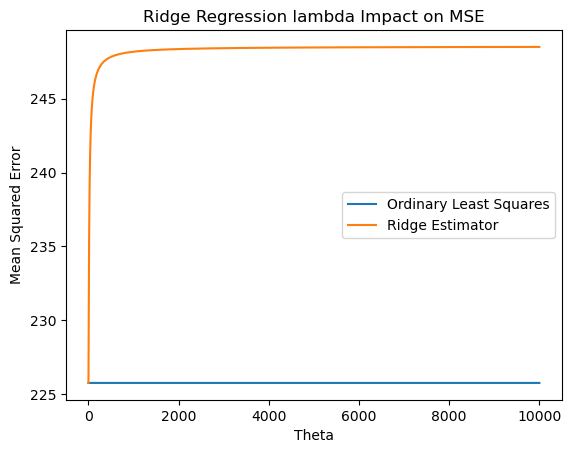

In [10]:
plt.plot(lamda_ls, np.full_like(lamda_ls, ols_mse), label="Ordinary Least Squares")
plt.plot(lamda_ls, ridge_mse_ls, label="Ridge Estimator")
plt.title("Ridge Regression lambda Impact on MSE")
plt.xlabel("Theta")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

b) We can see that any regularization results in a worse MSE for our estimator. This seems logical since, as we established in our previous assignment, the models are extremely sensitive to the regularization parameter, meaning that any value higher than 0.001 may result in all our parameters being pushed to 0.

## Exercise 20

a) $(E_D[f(x;D)- E[y|x]])^2 $, representing the optimal MSE of the estimator, becomes 0 if the estimator can perfectly predict all original data points. This is possible by correctly guessing the general generator distribution and with an infinite dataset ($D: N \rightarrow \infty$).

b) This cannot be achieved in practice since any dataset will have some noise, which incurs a minimum variance penalty of at least $\sigma_n^2$ to any estimator. The variance caused by the noise can only converge to 0 in the case of inifite data points ($D: N \rightarrow \infty$), which is obviously impossible in the real world. 

## Exercise 21

a) We can prove $p(x,y)$ is a pdf by proving that 
$$
\int_0^1\int_{x^3}^1 p(x,y) dydx = 1
$$

$$
\int_0^1\int_{x^3}^1 p(x,y) dydx = 
\int_0^1\int_{x^3}^1 \frac{4}{3} dydx =
\int_0^1 \frac{4}{3}(1-x^3) dx =
\int_0^1 \frac{4}{3} - \frac{4}{3} x^3 dx =
\frac{4}{3} - \int_0^1 \frac{4}{3} x^3 dx = 
\frac{4}{3} - \frac{1}{4} \frac{4}{3} [1-0]^4 =
\frac{4}{3} - \frac{1}{3} = 1
$$

b) 
$$
p_X(x) = \int^1_{x^3} p(x,y) dy = 
\int^1_{x^3} \frac{4}{3} dy = 
\frac{4}{3} - \frac{4}{3} x^3, x \in[0,1]
$$

c) 
$$
p(y|x) = \frac{p(x,y)}{p_X(x)} = 
\frac{\frac{4}{3}}{\frac{4}{3} - \frac{4}{3} x^3} = 
\frac{1}{1 - x^3}
$$

d) 
$$
E[y|x] =
\int^1_{x^3} y p(y|x) dy =
\int^1_{x^3} y \frac{1}{1 - x^3} dy =
\frac{1}{1 - x^3} \int^1_{x^3} y dy = 
\frac{1}{1 - x^3} [\frac{y^2}{2}]^{1}_{x^3} =
\frac{1-x^6}{2(1-x^3)}
$$

## Exercise 22

a) 
For any multivariate joint distribution, we can find the optimal MSE estimate with the following formula:

$$
E[y|x] =  \mu_y + \alpha \frac{\sigma_y}{\sigma_x} (x-\mu_x) 
$$

For the multivariate, jointly distributed normal distribution, it holds that:

$$\alpha = \frac{\sigma_{xy}}{\sigma_x \sigma_y}$$ therefore:
$$E[y|x] = \mu_y + \frac{\sigma_{xy}}{\sigma_x^2} (x-\mu_x)$$

and in our case it would be computed like so:
$$
E[y|x] = 1 + \frac{3}{5} (x-1) = \frac{3}{5}x + \frac{2}{5} = y
$$

In [11]:
mean = np.array([1, 1])
cov = np.array([[4, 3],[3, 5]])

# 100 LS_Models of 50 elements each (y,x)
models_50 = [LS_Model.from_normal_dataset(mean=mean, cov=cov, size=50) for i in range(100)]

models_50[0].y[:3], models_50[0].x[:3]

(array([ 1.35448175, -1.61525305,  0.7462538 ]),
 array([[ 1.        ,  0.95798465],
        [ 1.        , -1.75670469],
        [ 1.        ,  1.81664757]]))

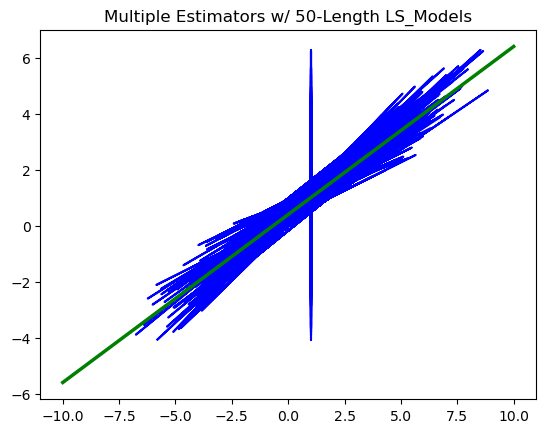

In [12]:
def plot_estimates(model_ls: list[LS_Model]) -> None:   
    # plot estimates
    for d in model_ls:
        plt.plot(d.x, d.estimate(), color="blue")
        
    # plot true line
    x_sample = np.linspace(-10, 10)
    y_true = x_sample * (3/5) + 2/5
    plt.plot(x_sample, y_true, color="green", linewidth=2.5)
    
    plt.title(f"Multiple Estimators w/ {d.x.shape[0]}-Length LS_Models")
    plt.show()

    
plot_estimates(models_50)

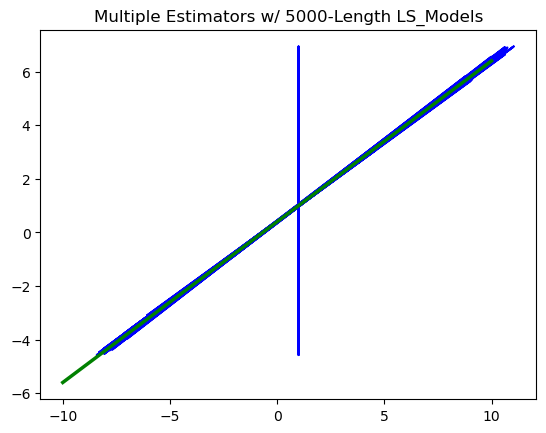

In [13]:
models_5000 = [LS_Model.from_normal_dataset(mean=mean, cov=cov, size=5000) 
                 for i in range(100)]

plot_estimates(models_5000)

f) By comparing the graphs above, we notice that the estimations converge on the actual solution much more "tightly" in the case of the $5000$-length dataset. This makes sense, since the estimator for $N=5000$ has a much smaller variance than the corresponding $N=50$ estimator.  

We can verify this conclusion by considering the MSE equations for the estimators,

$E_D[f(x;D) - E_D[f(x;D)])^2]$, where $E_D[f(x;D)]$ converges on the true mean of $f$ with larger $N$ values.

## Exercise 23

In [14]:
model_test = LS_Model.from_normal_dataset(mean=mean, cov=cov, size=50)
model_train = LS_Model.from_normal_dataset(mean=mean, cov=cov, size=100) 

In [15]:
theta = model_train.fit()
print(f"Linear estimate: y = {theta[1]:2f}x + {theta[0]:2f}")

Linear estimate: y = 0.614406x + 0.549436


In [16]:
estimates = model_test.x @ theta
print("Test data estimates: ", estimates)

Test data estimates:  [-0.61682048  2.86137394  2.7394747  -1.01781899 -0.14680296  1.96778021
  1.41513721 -0.085058    2.15317448 -1.32561094  0.90389387  0.09092894
  0.92522492 -0.46826441  1.20788585  0.72977013  0.23113429 -0.12670235
 -0.06673283 -1.12129073  1.12466541  0.08600249  2.5598006   1.65658425
  2.10998615  1.83881403  2.92231245  3.0770914  -0.87859983  0.29681142
  1.44165687  0.06929452  2.7124084   1.99205176  0.63108721  1.74563324
  2.29995677  3.17276891 -0.57582299  0.81451764 -0.39909084  0.36588377
 -0.79769296  2.37141912  0.79910717  1.73401576  0.07431152  1.95877264
  1.57722034  0.05719571]


We can now test how well our new estimator fits unknown data by calculating the MSE and LogLikelihood for the data generated by `model_test`.

In [17]:
def logLikelihood(estimates: np.ndarray, y: np.ndarray) -> float:
    """
    Get the log likelihood of a LS model.
    :param estimates: the estimates
    :param estimates: the true data points
    :return: the loglikelihood of the model's estimates
    """
    n = estimates.shape[0]
    residuals = (estimates - y)**2 
    return -(n * 1/2) * (1 + np.log(2 * np.pi)) - (n / 2) * np.log(residuals @ residuals / n)

# model.y represents the true E[Y|x] distribution
print(f"LogLikelihood={logLikelihood(estimates, model_test.y):2f}, MSE={mse(estimates, model_test.y)}")

LogLikelihood=-130.829753, MSE=2.2147634539004164


## Exercise 24

We will create two datasets based on the distribution $\hat{y}(x) = E[y|x]$, as defined in Exercise 21, adding some normal noise:

In [18]:
x = np.random.uniform(0,1, 100)
y = (1-x**6) / 2*(1-x**3) + np.random.normal(0, 1)

model = LS_Model(x=x, y=y, include_coef_col=True)

And generate its MSE after applying the least squares method:

In [19]:
mse(model.estimate(), model.y)

0.003887460243768801

We will now manually compute the MSE estimate for a multivariate gaussian distribution as follows:

In [20]:
m = np.array([model.x[:,1].mean(), model.y.mean()])

z = np.array([model.x[:,1], model.y]).T
cov = (m-z).T@(m-z)
cov

array([[ 9.4540454 , -4.74188864],
       [-4.74188864,  2.76714669]])

In [21]:
gauss_estimate = m[1] + cov[0,1] / cov[1,1] * (model.x[:,1] - m[0])
mse(gauss_estimate, model.y)

0.14277719279525802

We can observe that the MSE between the Least Squares criterion in the dataset we created is far lower than the optimal MSE estimate derived from the multivariate Gaussian distribution. This happens because the gaussian assumption, which generates the estimations in the equation above, is violated. We can verify this by checking the original $p(y,x)$ pdf, from Exercise 21, which in turn generated the geneator function $E[y|x]$, which was used to generate our data.

In practise however, the calculation of $E[y|x]$ is either impossible (since it too requires the exact generator distribution) or computationally intractable. Thus, we can not rely on the $E[y|x]$ MSE to judge our gaussian estimator.